In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *
from tqdm import tqdm


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl


ROOT_DIR = Path(os.getcwd()).parent.parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="VIBBTC", time="2021-09-05 17:00:05", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    start: pd.Timestamp = pump.time.floor("1h") - lookback_delta
    end: pd.Timestamp = pump.time.floor("1h")

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in tqdm(date_range):
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(
                ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name
            )
        )
        
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")

    # df = df[
    #     (df["time"] >= start) & (df["time"] < end - timedelta(hours=1))
    # ].reset_index(drop=True)

    return df

In [4]:
df: pd.DataFrame = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["price"] * df["qty"]
df.head()

100%|██████████| 31/31 [00:01<00:00, 23.83it/s]


,price,qty,time,isBuyerMaker,quote
0,9.200000e-07,191.0,2021-08-06 00:00:24.912,False,0.000176
1,9.200000e-07,279.0,2021-08-06 00:04:32.583,False,0.000257
2,9.200000e-07,150.0,2021-08-06 00:13:27.992,False,0.000138
3,9.100000e-07,372.0,2021-08-06 00:22:03.915,True,0.000339
4,9.200000e-07,964.0,2021-08-06 00:29:20.558,False,0.000887


<h4>Create features. 26-05</h4>

In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]


df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0
df_trades["quote_long"] = df_trades["quote_abs"] * df_trades["is_long"]
df_trades["quote_short"] = df_trades["quote_abs"] * ~df_trades["is_long"]

df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long,quote_long,quote_short
0,2021-08-06 00:00:24.912,9.200000e-07,9.200000e-07,9.200000e-07,9.200000e-07,191.0,191.0,0.000176,0.000176,True,0.000176,0.0
1,2021-08-06 00:04:32.583,9.200000e-07,9.200000e-07,9.200000e-07,9.200000e-07,279.0,279.0,0.000257,0.000257,True,0.000257,0.0


<h4>Plot imbalance ratio</h4>

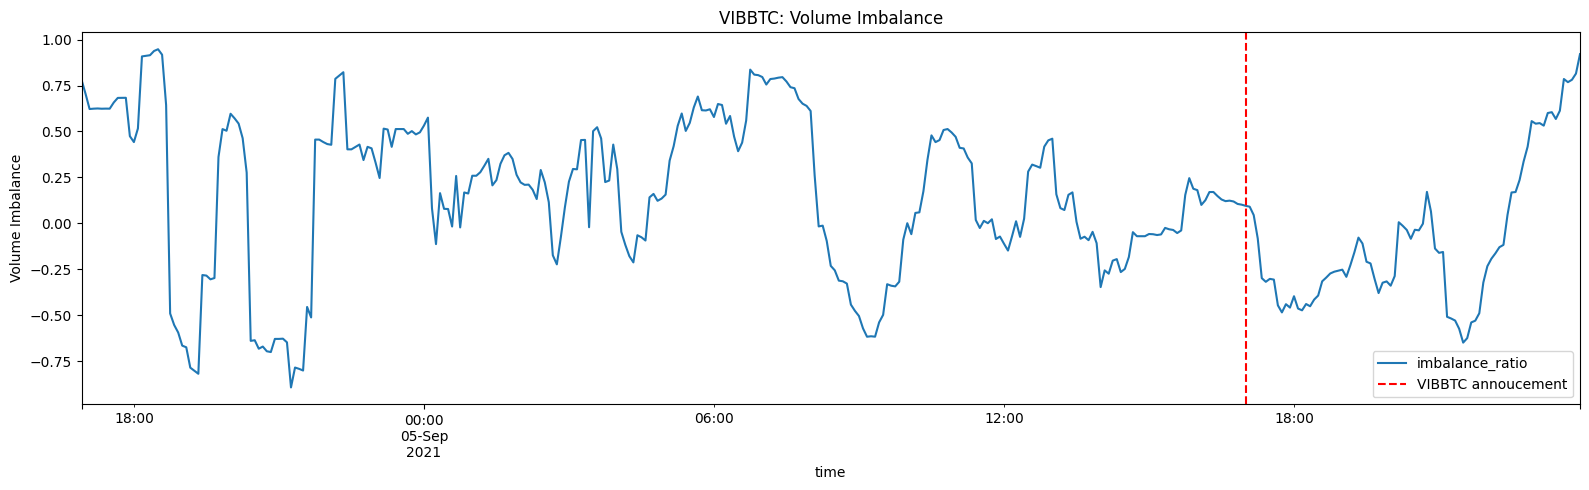

In [6]:
df = pl.from_pandas(df_trades)

df = df.filter(
    pl.col("time") >= pump.time.floor("1h") - timedelta(days=1)
)

df = df.with_columns(
    time=pl.col("time").set_sorted()
)

df.group_by_dynamic(
    index_column="time", every="5m", period="1h"
).agg(
    imbalance_ratio = pl.col("quote_sign").sum() / pl.col("quote_abs").sum()
).to_pandas().plot(
    x="time", y="imbalance_ratio", figsize=(16, 5)
)

plt.title(f"{pump.ticker}: Volume Imbalance")
plt.axvline(x=pump.time, color="red", linestyle="--", label=f"{pump.ticker} annoucement")
plt.ylabel("Volume Imbalance")

plt.legend()
plt.tight_layout()
plt.savefig("volume_imbalance.png", transparent=True)

plt.show()

<h4>Draw seconds candlestick plot</h4>

In [7]:
df_plot: pd.DataFrame = df_trades[
    (df_trades["time"] >= pump.time - timedelta(seconds=60)) &
    (df_trades["time"] <= pump.time + timedelta(seconds=20))
].copy()


df_candles_1s = df_plot.resample(on="time", rule="1s").agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    volume=("quote_abs", "sum")
)

df_candles_1s.head(1)

,open,close,low,high,volume
time,,,,,
2021-09-05 16:59:08,0.000002,0.000002,0.000002,0.000002,0.001036


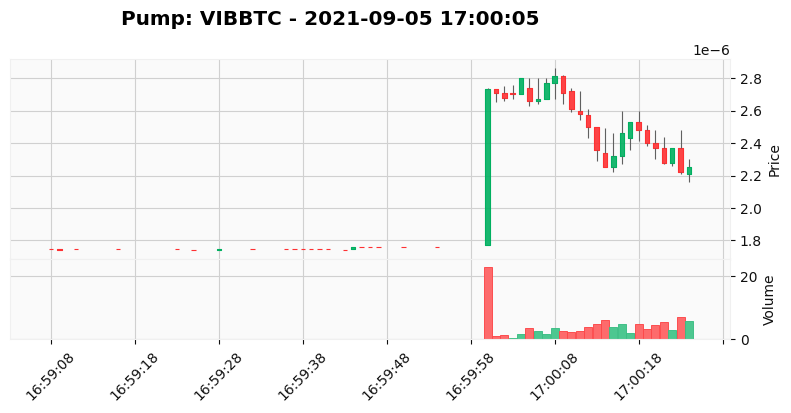

In [8]:
import mplfinance as mpf


mpf.plot(
    df_candles_1s, type="candle", style="yahoo", volume=True,
    title=f"Pump: {pump.ticker} - {pump.time}", figsize=(10, 4),
    datetime_format="%H:%M:%S"
)

<h4>BTC slippage</h4>

$$\text{BTC\_lost\_to\_slippage} = \underbrace{\sum_{i=1}^{N}{\text{qty\_sign}_i} \cdot P_i}_{\text{Quote actually spent}} - \underbrace{\sum_{i=1}^N{\text{qty\_sign}_i} \cdot P_0}_{\text{Quote could have been spent if filled at best price}}$$

In [9]:
df_trades["quote_slippage_abs"] = (
    df_trades["quote_sign"] - df_trades["qty_sign"] * df_trades["price_first"]
)
df_trades["quote_slippage_sign"] = df_trades["quote_slippage_abs"] * np.sign(df_trades["qty_sign"])

# Long, short quote slippage
df_trades["quote_slippage_abs_long"] = df_trades["quote_slippage_abs"] * df_trades["is_long"]
df_trades["quote_slippage_abs_short"] = df_trades["quote_slippage_abs"] * ~df_trades["is_long"]

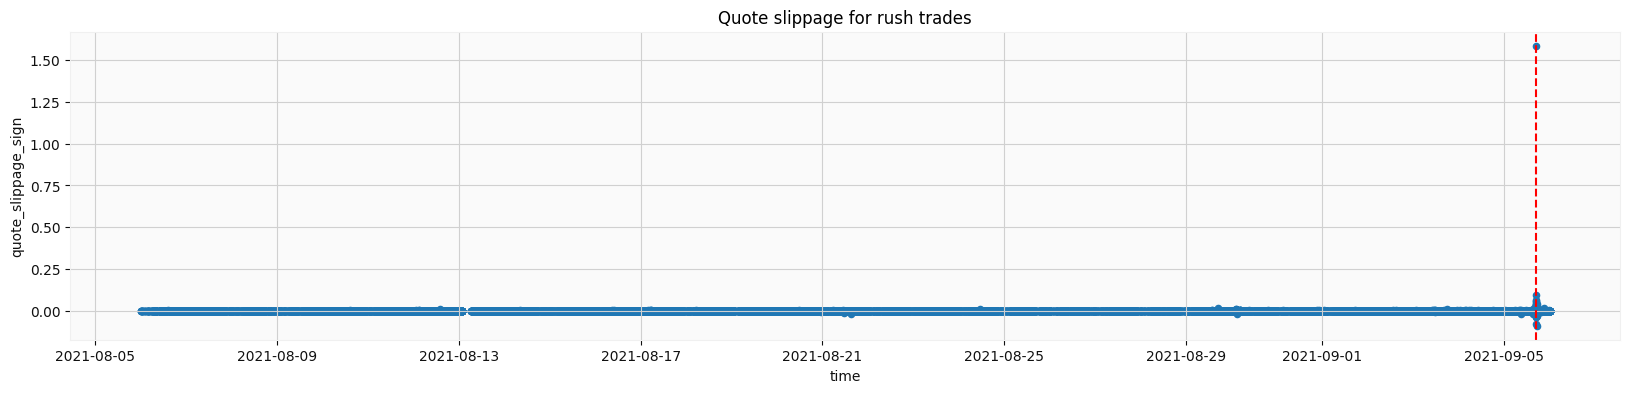

In [10]:
df_trades.plot.scatter(x="time", y="quote_slippage_sign", figsize=(20, 4))
plt.title("Quote slippage for rush trades")
plt.axvline(x=pump.time, color="red", linestyle="--")
plt.show()

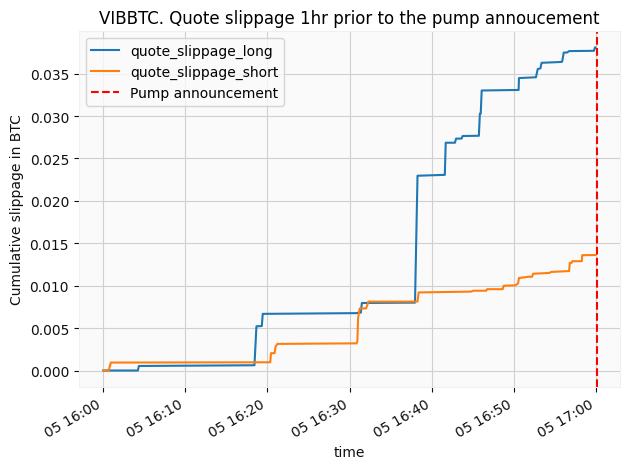

In [42]:
df_plot = df_trades[
    (df_trades["time"] >= pump.time.floor("1h") - timedelta(hours=1)) &
    (df_trades["time"] <= pump.time.floor("1h"))
].copy()


df_plot["quote_slippage_abs_long_cumsum"] = df_plot["quote_slippage_abs_long"].cumsum()
df_plot["quote_slippage_abs_short_cumsum"] = df_plot["quote_slippage_abs_short"].cumsum()


df_plot.plot(
    x="time", y=["quote_slippage_abs_long_cumsum", "quote_slippage_abs_short_cumsum"], 
    label=["quote_slippage_long", "quote_slippage_short"]
)

plt.title(f"{pump.ticker}. Quote slippage 1hr prior to the pump annoucement")
plt.axvline(x=pump.time, color="red", linestyle="--", label="Pump announcement")

plt.ylabel("Cumulative slippage in BTC")
plt.legend()
plt.tight_layout()

plt.savefig("quote_slippage.png", transparent=True)
plt.show()

In [11]:
time_ub: pd.Timestamp = pump.time.floor("1h") - timedelta(hours=1)

df_train = df_trades[df_trades["time"] <= time_ub].copy()

<h4>Features calculated over shorter time frame</h4>

In [12]:
# Interval based features

hour_bins: List[int] = [1, 3, 12, 24, 36, 48, 60, 72]

df_72h = df_trades[
    df_trades["time"] >= time_ub - timedelta(hours=72)
].copy()

df_num_trades_72h: pd.DataFrame = df_72h.resample(on="time", rule="5min").agg(
    num_trades=("is_long", "count")
)


features_3d: Dict[str, float] = {}


for hour in hour_bins:
    df_interval: pd.DataFrame = df_train[df_train["time"] >= time_ub - timedelta(hours=hour)].copy()

    # Number of trades features
    long_short_trades_ratio: float = df_interval["is_long"].sum() / (~df_interval["is_long"]).sum()
    long_trades_share: float = df_interval["is_long"].sum() / df_72h["is_long"].sum() # share of long trades within this bin from 72hours
    short_trades_share: float = (~df_interval["is_long"]).sum() / (~df_72h["is_long"]).sum() # share of short trades within bin from 72hours

    # Volume features in quote assets
    long_quote_volume_share: float = df_interval["quote_long"].sum() / df_72h["quote_long"].sum() # share of long volume from 72 hours
    short_quote_volume_share: float = df_interval["quote_short"].sum() / df_72h["quote_short"].sum()

    # Imbalance ratio
    imbalance_ratio: float = df_interval["quote_sign"].sum() / df_interval["quote_abs"].sum()

    # Quote slippages
    quote_slippage_imbalance_ratio: float = df_interval["quote_slippage_sign"].sum() / df_interval["quote_slippage_abs"].sum()
    quote_slippage_share: float = df_interval["quote_slippage_abs"].sum() / df_72h["quote_slippage_abs"].sum()
    quote_slippage_long_short_ratio: float = (
        df_interval["quote_slippage_abs_long"].sum() / df_interval["quote_slippage_abs_short"].sum()
    )
    quote_slippage_long_share: float = df_interval["quote_slippage_abs_long"].sum() / df_72h["quote_slippage_abs_long"]
    
    # Share of slippages in overall volume
    quote_slippage_quote_share: float = df_interval["quote_slippage_abs"].sum() / df_interval["quote_abs"].sum()

    # Empty trading bins - count how many trading bins were empty (no trades)
    df_num_trades: pd.DataFrame = df_interval.resample(on="time", rule="5min").agg(
        num_trades=("is_long", "count")
    )
    empty_5m_bins_share = df_num_trades[df_num_trades["num_trades"] == 0].shape[0] / df_num_trades.shape[0]

    # Do the same but over 72h
    empty_5m_bins_share_72h = (
        df_num_trades[df_num_trades["num_trades"] == 0].shape[0] / 
        df_num_trades_72h[df_num_trades_72h["num_trades"] == 0].shape[0]
    )


    # Add features
    features_3d.update({
        f"long_short_trades_ratio_{hour}h": long_short_trades_ratio,
        f"long_trades_share_{hour}h_72H": long_trades_share,
        f"short_trades_share_{hour}h_72H": short_trades_share,

        f"long_quote_volume_share_{hour}h_72H": long_quote_volume_share,
        f"short_quote_volume_share_{hour}h_72H": short_quote_volume_share,

        f"imbalance_ratio_{hour}h": imbalance_ratio,

        f"quote_slippage_imbalance_ratio_{hour}h": quote_slippage_imbalance_ratio,
        f"quote_slippage_share_{hour}h_72H": quote_slippage_share,
        f"quote_slippage_long_short_ratio_{hour}h": quote_slippage_long_short_ratio,
        f"quote_slippage_quote_share_{hour}h_72H": quote_slippage_quote_share,

        f"empty_5m_bins_share_{hour}h": empty_5m_bins_share,
        f"empty_5m_bins_share_{hour}h_72H": empty_5m_bins_share_72h
    })

len(features_3d)

96

<h4>Powerlaw features (daily bins)</h4>

In [13]:
from scipy.stats import powerlaw


daily_bins: List[int] = [1, 2, 3, 5, 7, 14]
features_powerlaw: Dict[str, float] = {}


for days in daily_bins:
    df_interval: pd.DataFrame = df_train[df_train["time"] >= time_ub - timedelta(days=days)].copy()

    alpha_quote_abs: float = powerlaw.fit(df_interval["quote_abs"])[0]
    alpha_quote_abs_long: float = powerlaw.fit(df_interval["quote_long"])[0]
    alpha_quote_abs_short: float = powerlaw.fit(df_interval["quote_short"])[0]

    features_powerlaw.update({
        f"alpha_quote_abs_{days}d": alpha_quote_abs,
        f"alpha_quote_abs_long_{days}d": alpha_quote_abs_long,
        f"alpha_quote_abs_short_{days}d": alpha_quote_abs_short
    })


len(features_powerlaw)

d:\Pumps\env\Lib\site-packages\scipy\stats\_continuous_distns.py:8410: RuntimeWarning: overflow encountered in divide
  return (shape - 1) * np.sum(1 / (loc - data))  # -1/(data-loc)
d:\Pumps\env\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


18

<h4>Quote interval features: Quantile ratios</h4>

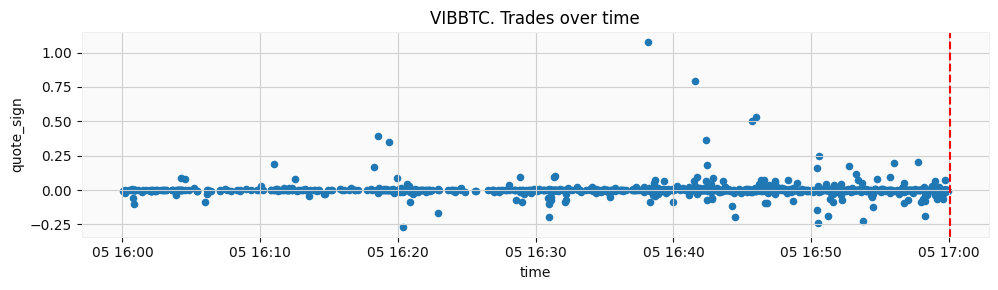

In [49]:
df_plot.plot.scatter(x="time", y="quote_sign", figsize=(10, 3))
plt.title(f"{pump.ticker}. Trades over time")
plt.axvline(x=pump.time, color="red", linestyle="--")

plt.tight_layout()
plt.savefig("quote_sizes.png", transparent=True)
plt.show()

In [15]:
daily_bins: List[int] = [1, 2, 3, 5, 7, 14]
features_quantiles: Dict[str, float] = {}


for days in daily_bins:

    df_interval: pd.DataFrame = df_train[df_train["time"] >= time_ub - timedelta(days=days)].copy()

    quote_sign_kurt: float = df_interval["quote_sign"].kurt()
    quote_sign_skew: float = df_interval["quote_sign"].skew()

    # Find quote long short quantiles
    quote_long_999_quantile: float = df_interval["quote_long"].quantile(.999)
    quote_short_999_quantile: float = df_interval["quote_short"].quantile(.999)

    quote_long_99_quantile: float = df_interval["quote_long"].quantile(.999)
    quote_short_99_quantile: float = df_interval["quote_short"].quantile(.999)

    quote_long_95_quantile: float = df_interval["quote_long"].quantile(.999)
    quote_short_95_quantile: float = df_interval["quote_short"].quantile(.999)

    features_quantiles[f"long_short_999_quantile_ratio_{days}d"]= quote_long_999_quantile / quote_short_999_quantile
    features_quantiles[f"long_short_99_quantile_ratio_{days}d"] = quote_long_99_quantile / quote_short_99_quantile
    features_quantiles[f"long_short_95_quantile_ratio_{days}d"]= quote_long_95_quantile / quote_short_95_quantile

    features_quantiles[f"long_999_99_quantile_ratio_{days}d"] = quote_long_999_quantile / quote_long_99_quantile
    features_quantiles[f"long_99_95_quantile_ratio_{days}d"] = quote_long_99_quantile / quote_long_95_quantile


len(features_quantiles)

30

<h4>Hourly candles features</h4>

In [16]:
df_candles_1h: pd.DataFrame = df_train.resample(
    on="time", rule="1h", label="left", closed="left"
).agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    num_trades=("quote_abs", "count"),
    num_long_trades=("is_long", "sum"),
    quote_abs=("quote_abs", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_long=("quote_long", "sum"),
    quote_slippage_abs=("quote_slippage_abs", "sum"),
    quote_slippage_sign=("quote_slippage_sign", "sum")
).reset_index()

df_candles_1h.head(1)

,time,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_long,quote_slippage_abs,quote_slippage_sign
0,2021-08-06,9.200000e-07,9.200000e-07,9.100000e-07,9.200000e-07,8,7,0.012312,0.011635,0.011974,4.336809e-19,4.336809e-19


In [17]:
# compute log returns
df_candles_1h["close"] = df_candles_1h["close"].ffill()
df_candles_1h["log_returns"] = np.log(df_candles_1h["close"] / df_candles_1h["close"].shift(1))
df_candles_1h = df_candles_1h.iloc[1:]
df_candles_1h = df_candles_1h.reset_index()

df_candles_1h.head(1)

,index,time,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_long,quote_slippage_abs,quote_slippage_sign,log_returns
0,1,2021-08-06 01:00:00,9.200000e-07,9.100000e-07,9.100000e-07,9.200000e-07,3,1,0.044203,-0.04165,0.001277,6.938894e-18,-6.938894e-18,-0.010929


In [18]:
hour_bins: List[int] = [1, 3, 12, 24, 36, 48, 60, 72]

df_candles_1h_72H = df_candles_1h[
    df_candles_1h["time"] >= time_ub - timedelta(hours=72)
].copy()

features_candles_1h: Dict[str, float] = {}


for hour in hour_bins:
    df_interval: pd.DataFrame = df_candles_1h[df_candles_1h["time"] >= time_ub - timedelta(hours=hour)].copy()

    features_candles_1h[f"hourly_log_return_{hour}h_zscore_72H"] = df_interval["log_returns"].mean() / df_candles_1h_72H["log_returns"].std()
    features_candles_1h[f"hourly_log_return_{hour}h_std"] = df_interval["log_returns"].std()

    features_candles_1h[f"hourly_volume_{hour}h_std_72H_std"] = df_interval["quote_abs"].std() / df_candles_1h_72H["quote_abs"].std()

In [19]:
features_candles_1h

{'hourly_log_return_1h_zscore_72H': 0.9193767629920717,
 'hourly_log_return_1h_std': nan,
 'hourly_volume_1h_std_72H_std': nan,
 'hourly_log_return_3h_zscore_72H': 0.5138953174077431,
 'hourly_log_return_3h_std': 0.019525243051472546,
 'hourly_volume_3h_std_72H_std': 4.0391571216158475,
 'hourly_log_return_12h_zscore_72H': 0.37005178206034395,
 'hourly_log_return_12h_std': 0.040766372434696184,
 'hourly_volume_12h_std_72H_std': 2.1138508594366505,
 'hourly_log_return_24h_zscore_72H': 0.3726713605652121,
 'hourly_log_return_24h_std': 0.029852775612243747,
 'hourly_volume_24h_std_72H_std': 1.5867035733019472,
 'hourly_log_return_36h_zscore_72H': 0.22846395945247433,
 'hourly_log_return_36h_std': 0.024884169006026392,
 'hourly_volume_36h_std_72H_std': 1.3338715568555473,
 'hourly_log_return_48h_zscore_72H': 0.2405329900632424,
 'hourly_log_return_48h_std': 0.022639606097218948,
 'hourly_volume_48h_std_72H_std': 1.1694103541807626,
 'hourly_log_return_60h_zscore_72H': 0.20523410237986772,
